<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS207 Project Milestone 2  - @Software-Samurais</h1> 
    
### Group 3: 
#### Erick Ruiz, Jingyuan Liu, Kailas Amin, Simon (Xin) Dong



<hr style='height:2px'>

In [1]:
from IPython.display import Latex


# 1 Introduction

The increasing importance of computational models in science and business alongside the slowing pace of advances in computing hardware has increased the need for efficient and accurate evaluations of derivatives. Many important applications such as simulation, opti- mization, and neural networks rely on repeated differentiation of complex functions.

Before the advent of automatic differentiation (AD) the primary method for derivative evaluation was the method of finite differences (FD), where the function to be evaluated is effectively treated as black box oracle.1 As the FD method is effectively sampling, the granularity (i.e. step size) of the algorithm can introduce error effects if it is either too large or too small, but even at the perfect medium, f′(x) evaluations cannot reach machine precision. The alternative approach, fully symbolic differentiation (SD), is cumbersome and inefficient in many cases. In the case of a complex computer program, the size of the symbolic expression could grow to outrageous size and cause significant inefficiency.

The approach of algorithmic differentiation seeks to find the best of both worlds, with machine precision and easy evaluation. This is done by repeated evaluation of the chain rule at a point stored in a table called the computational trace. Thus rather than storing to full symbolic expression, an AD code only needs to apply the chain rule to a specific evalua- tion, representable by a single variable. This approach allows us to achieve the accuracy of symbolic approaches while drastically reducing the cost of evaluation.
Within the umbrella of automatic differentiation, we seek to implement the forward mode which evaluates the intermediate results directly in an inside out manner. Other approaches such as reverse mode also have specific advantages especially in the fields of machine learning and artificial intelligence– or in any context in which the number of inputs dominates the number of outputs.

The method of automatic differentiation, sometimes also referred to as algorithmic differ- entiation, addresses the weaknesses of the finite difference method by providing a systematic way to calculate derivatives numerically to arbitrary precision. The goal of AutoDiff is to implement the forward mode of automatic differentiation, as it is a relevant feature that even some mainstream machine learning libraries, such as PyTorch, lack.


# 2 Background
Understanding the concept of a derivative is crucial to all aspiring and
practicing scientists, engineers, and mathematicians. It is one of the
first concepts introduced in first-year calculus courses at all
universities. The idea is simple. Given a function, $f(x)$, how can we
quantify the rate of change of the function due to an infinitesimal
change, $\Delta x$, in the argument, $x$? The answer is typically given
in terms of the limit definition of the derivative.
\begin{equation}
f'(x) = \lim_{\Delta x\rightarrow 0} \frac{f(x+\Delta x)-f(x)}{\Delta x}
\tag{1}
\end{equation}

While equation (1) holds for any function, in practice, it is
easier to calculate derivatives analytically according to a set of
rules. However, obtaining an analytical expression for the derivative
becomes exceedingly difficult if the function of interest is composed of
many elementary functions.\
In any case of a derivative evaluating program, we will need to create a
code which takes as inputs both a function and evaluation point and then
return the derivative at that point. There are many approaches to
perform this calculation.\
For example, consider the following function.

\begin{equation}
f(x) = \exp\left[\frac{\sqrt{x^3 - \ln x + \sin(4x^2)}}{\cos(3x^5)}\right]
\tag{2}
\end{equation}

Calculating the first derivative would result
in the following expression. 
\begin{equation}
\begin{aligned}
    f'(x) &= \exp\left[\frac{\sqrt{x^3 - \ln x + \sin(4x^2)}}{\cos(3x^5)}\right]
    \sec^2(3x^5)\dots\nonumber\\
    &\qquad\times\left\{
    \frac{\cos(3x^5)}{2\sqrt{x^3 - \ln x + \sin(4x^2)}}
    \left[3x^2-\frac{1}{x}+8x\cos(4x^2)\right]\dots\right.\nonumber\\
    &\qquad\qquad+
    \left.\vphantom{\frac{\cos(3x^5)}{2\sqrt{x^3 - \ln x + \sin(4x^2)}}}
    15x^4\sin(3x^5)\sqrt{x^3 - \ln x + \sin(4x^2)}
    \right\}\end{aligned}
\tag{3}
\end{equation}

Although feasible, successive calculations
become more and more complex, and in practice, the quantity to be
differentiated may not be a function in closed-form but rather a set of
measurements or values given as a one-dimensional vector of numbers. In
that case, equation (1) can be approximated using the finite difference
method, which replaces an infinitesimal change in the argument for a
finite change. To show how this works, let us write the Taylor series
expansion of an arbitrary function, $f(x)$, at the point $x+h$.

\begin{equation}
f(x+h) = f(x) + hf'(x) + \frac{h^2}{2}f''(x) + \dots
    \tag{4}
\end{equation}

Keeping only terms of $\mathcal{O}(h)$ leaves us
with 

\begin{equation}
f(x) \approx f(h) + hf'(x),
\tag{5}
\end{equation}
which we can rearrange to write an
approximate expression for the derivative, $f'(x)$.

\begin{equation}
f'(x) \approx \frac{f(x+h)-f(x)}{h}
    \tag{6}
\end{equation}

The finite change, $h$, is called the step size, and
equation (6) is known as the forward difference. Its geometric interpretation is
described in Figure 1.<img src="./img/figure1.jpeg" width = "600" alt="name1" align=center />

Although the finite difference method is useful and easy to implement,
its accuracy can vary depending on the step size that is chosen. Suppose
we wish to approximate the derivative of $f(x)=\ln x$ using the forward
difference method described in equation (6) using step
sizes $h=\{10^{-1},\,
10^{-7},\,10^{-15}\}$. This is rather unnecessary because the analytical
derivative is just $f'(x) = 1/x$, but this example will serve to
illustrate the drawbacks of the finite difference method. At
$h=10^{-1}$, the numerical derivative is inaccurate because the step
size is too large, making the calculations susceptible to truncation
error. Conversely, at $h=10^{-15}$, the forward difference method also
gives inaccurate results because the calculations can only be
represented to a finite precision by the hardware in use. Hence,
rounding error also affects the stability of the finite difference
method.

In order to evaluate the derivative via forward mode AD we first
construct a computational graph which encodes the composition and
dependence of sub-function evaluations. It is important to note that
each elementary function evaluation needs to be understood at a symbolic
level! After constructing the graph, the chain rule is simply applied
successively to evaluations at a single point which then generates a
table known as the computational trace. To illustrate the concept,
consider the following example, adapted from *Evaluating derivatives:
principles and techniques of algorithmic differentiation* by Griewank
and Walther.
\begin{equation}
f(x,y) = \left[\sin\left(\frac{x}{y}\right) + \frac{x}{y} - \exp(y)\right]
    \left[\frac{x}{y} - \exp(y)\right]
    \tag{7}
\end{equation}
A function of two arguments (i.e. variables $x$ and
$y$) like the one in equation (7) can be
evaluated at point by replacing the arguments with numerical values. The
series of calculations needed to carry out the evaluation can be
visualized as a computation graph, as shown in Figure 2.<img src="./img/figure2.png" width = "800" alt="name" align=center />
The graph helps visualize the order of the
computations, and it also establishes the dependence of successive
calculations on previous ones.\
Although in many cases, the AD approach is given the entire function as
input, this is not always the case. This necessitates the need for a
\"seed\" value. In the basic case when the entire function is given, we
can simply initialize the computational trace (discussed below) as 1.
However, given the need for modularity which respects the chain rule, it
is also possible to input a different seed, allowing for the integration
of AD onto a sub segment of the function.

\
The procedure for constructing such a graph is the following. Define a
node for each of the inputs using a new variable. For this example, we
will let $x_1 = x$ and $x_2 = y$. From there, any successive nodes may
accept two inputs at maximum, and each node represents a new
calculation. For example, in the computational graph shown in Figure 3, the node $x_3$ represents the calculation
$x_1/x_2$, which later becomes an input in successive nodes. While the
computational graph is useful for visualizing the entire computation
procedure, the computational trace is useful for storing values as the
computation is carried out. The computational trace for
$f(1.5000, 0.5000)$ is given in Table 1![Table1](img/table1.png) In reference to the above, we can note that in
this trace, the seed is 1 and thus suppressed as is often notated. In
addition, it is important to note that depending on what implementation
of forward mode the exact target computed can be slightly different. In
particular, the vectorized extension of our milestone 2 code computes
the Jacobian.

Beyond the basic forward mode, there exists other implementations of AD
in the so called "reverse mode\". This approach can increase efficiency
significantly in cases when the number of inputs is far greater than the
number of outputs.


# 3 How to use
## 3.1 <span id="jump">Installation</span>

The `github` url to the project is https://github.com/Software-Samurais/cs207-FinalProject.

We provide two ways for our package installation: PyPI and GitHub.
### Install from PyPI

We have already uploaded our GuruDiff package to PyPI. To use the GuruDiff package, users should first run the commands provided below to install our package via pip and import it.


- Install GuruDiff using pip:
```shell
pip install GuruDiff
```
- Import GuruDiff package to use
```Python
import GuruDiff.AD as AD
```

### Install from GitHub
- Download the package from GitHub to your folder via these commands (in the terminal)

```shell
# Clone the repo
git clone https://github.com/Software-Samurais/cs207-FinalProject.git

```

- Create a virtual environment and activate it (for Mac and Ubutun)

```shell
# If you don't have virtualenv, install it
sudo easy_install virtualenv
# Create virtual environment
virtualenv env
# Activate your virtual environment
source env/bin/activate
```

- Install the necessary dependencies :

```shell
pip install -r requirements.txt
```

- Run module tests (in the root directory):

```shell
# Run module tests if you like
python -m pytest ./test/test_forward.py ./test/test_reverse.py
```

## 3.2 Getting Started with `GuruDiff`

The following is a demonstration of `GuruDiff`'s capabilities to help the user hit the ground running. 

In [2]:
import sys 
# Adds a relative file path to this notebook
sys.path.append("..") 

import matplotlib.pyplot as plt
import numpy as np

import autodiff.AD as AD

## Declaring Variables and Performing Elementary Operations
### Scalar Variables
We may define a scalar variable as follows.

In [3]:
x = AD.Var(np.pi)

Note that we when a value for the derivative is not specified, a default value of `1.0` is assigned automatically.

In [4]:
# Display a variable's most relevant information
x

Function value:
3.141592653589793
Derivative value:
1.0

We also allow the user to specify a value for the derivative.

In [5]:
y = AD.Var(1.0, 3.0)
y

Function value:
1.0
Derivative value:
3.0

In addition, we may use scalar variables to define custom scalar functions composed of standard elementary operations.

In [5]:
def f(x):
    return x**2 + AD.cos(x) + 0.5*AD.exp(-x**2)

f(x)

Function value:
8.86963026268246
Derivative value:
6.283022813997788

<div class="alert alert-info"> 
    Since <code>x</code> is a forward mode variable, we must use the implementations of elementary functions defined in the <code>AD</code> module instead of the standard Numpy methods.
</div>

### Scalar Variables Using Arrays
Suppose we wish to define a scalar variable containing an array as the function value to visualize both the function and derivative values (e.g. plot $\sin x$). The `Var` class is versatile enough to handle this directly!

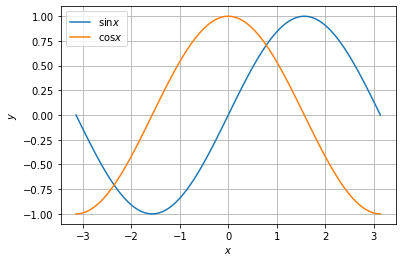

In [6]:
# Instance of the `Var` class with an array as the function value
x = AD.Var(np.linspace(-np.pi, np.pi, 100))

# Function to visualize
f1 = AD.sin(x)

# Plot function and derivative
plt.figure()
plt.plot(x.val, f1.val, label="$\sin x$")
plt.plot(x.val, f1.der, label="$\cos x$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.grid()
plt.show()

### Vector Function Variables
Suppose we have a vector-valued function of the form $\mathbf{f}(\mathbf{x}) \in \mathbb{R}^m$, where $\mathbf{x} \in \mathbb{R}^n$. Defining a variable for a vector function can be accomplished in a similar manner as before. As an example, consider the vector-valued function
\begin{equation}
    \mathbf{f}(\mathbf{x})
    =
    \begin{pmatrix}
        \sin x\\
        4y + z^3
    \end{pmatrix}.
\end{equation}
Calculating $\nabla\mathbf{f}$ yields the following Jacobian.
\begin{equation}
    \nabla\mathbf{f} 
    = 
    \begin{pmatrix}
        \cos x & 0 & 0\\
        0 & 4 & 3z^2
    \end{pmatrix}
\end{equation}

In [7]:
# Define scalar variables and their respective unit vectors
x = AD.Var(np.pi/2, [1, 0, 0])
y = AD.Var(3, [0, 1, 0])
z = AD.Var(-2, [0, 0, 1])

# Use the scalar variables to define vector-valued function
f = AD.Var([AD.sin(x), 4*y + z**3])
f

Function values:
[1. 4.]
Jacobian:
[[6.123234e-17 0.000000e+00 0.000000e+00]
 [0.000000e+00 4.000000e+00 1.200000e+01]]

### Demos

In [10]:
# ℝ1→ℝ1
x = AD.Var([np.pi/2])
f = AD.sin(x) + 5 * AD.tan(x/2)
f

Function value:
[6.]
Derivative value:
[5.]

In [11]:
# ℝm→ℝ1
x = AD.Var([np.pi/2], [1, 0])
y = AD.Var([1], [0, 1])
f = AD.sin(x) + AD.exp(y)
f

Function value:
3.718281828459045
Gradient:
[0.         2.71828183]

In [12]:
# ℝ1→ℝn
x = AD.Var([np.pi/2], [1])
f = AD.Var([AD.sin(x), x ** 2])
f

Function values:
[1.        2.4674011]
Derivative values:
[[0.        ]
 [3.14159265]]

In [13]:
#ℝm→ℝn
x = AD.Var([np.pi/2], [1, 0, 0])
y = AD.Var([3], [0, 1, 0])
z = AD.Var([-2], [0, 0, 1])
f = AD.Var([AD.sin(x), 4 * y + z ** 3])
f

Function values:
[1. 4.]
Jacobian:
[[ 0.  0.  0.]
 [ 0.  4. 12.]]

## Application: Newton's Method in Higher Dimensions

Newton's method is an iterative technique for finding the zeros of nonlinear functions. For scalar functions of a single variable (e.g. $f(x)$), the iterations may be calculated as follows.
\begin{equation}
    x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}
\end{equation}
Here, $x_{k+1}$ is the next iteration, $x_k$ is the previous iteration, and $f(x)$ is the function of interest.

The same technique can be generalized to encompass multivariate vector-valued functions. Suppose $\mathbf{f}(\mathbf{x}) \in \mathbb{R}^m$ is the differentiable function of interest. Then, the system of equations we wish to solve is $\mathbf{f}(\mathbf{x}) = \mathbf{0}$. Newton's method calculates the solution iteratively as follows.
\begin{equation}
    \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \delta\mathbf{x}^{(k)}
\end{equation}
Here, the second term on the right-hand side is defined as
\begin{equation}
    \delta\mathbf{x}^{(k)} = -\mathbf{J}\left(\mathbf{x}^{(k)}\right)^{-1}\mathbf{f}\left(\mathbf{x}^{(k)}\right),
\end{equation}
where $\mathbf{J}\left(\mathbf{x}^{(k)}\right)$ is the Jacobian evaluated at $\mathbf{x}^{(k)}$. In general, it is computationally expensive to explicitly calculate the inverse of a matrix, so instead, we obtain $\delta\mathbf{x}^{(k)}$ by solving the system
\begin{equation}
    \mathbf{J}\left(\mathbf{x}^{(k)}\right)\delta\mathbf{x}^{(k)} = -\mathbf{f}\left(\mathbf{x}^{(k)}\right)
\end{equation}
via Gaussian elimination.

In [8]:
def newton(f, x0, tol=1e-8, max_iter=100):
    """Newton's method for multivariate vector functions
    
    Parameters:
    ===========
    f (callable): vector function of interest
    x0 (array_like): initial guess in the form [x, y, z]
    tol (float): tolerance value; by default set to 1e-8
    max_iter (int): maximum number of iterations to execute
    
    Returns:
    ========
    xn (array): solution, if the algorithm converges
    
    """
    
    # Initial guess
    xn = x0
    
    for n in range(max_iter):
        
        # Evaluate f
        fn = f(*xn)
            
        # Calculate difference vector
        df = np.linalg.solve(fn.der, -fn.val)
        
        if abs(df).any() < tol:
            print(f"Found a solution after {n} iterations.")
            return np.around(xn, decimals=3)
        
        if np.linalg.det(fn.der) == 0:
            raise ValueError("Jacobian not invertible. No solution.")
        
        # Update the guess
        xn = xn + df
    
    print("Exceeded maximum number of iterations.")
    return None

In [9]:
# Example: Adapted from section 3.1 of "The Mathematics of Nonlinear Programming" by Peressini, Sullivan and Uhl
def f(x,y,z):
    X = AD.Var(x, [1, 0, 0])
    Y = AD.Var(y, [0, 1, 0])
    Z = AD.Var(z, [0, 0, 1])
    
    Fx = X**2 + Y**2 + Z**2 - 3
    Fy = X**2 + Y**2 - Z - 1
    Fz = X + Y + Z - 3
    
    val = np.asarray([Fx.val, Fy.val, Fz.val])
    jac = np.asarray([Fx.der, Fy.der, Fz.der])
    
    return AD.Var(val, jac)

In [10]:
newton(f, [1, 0, 1])

Found a solution after 27 iterations.


array([1., 1., 1.])

# 4 Software Organization

## 4.1 Directory Structure
The package's directory will be structured as follows:
``` py
Ccs207-FinalProject
    /autodiff                                           #Back-end source code
	    __init__.py                                     #Initialization
	    forward.py                                      #Forward mode: main file
        reverse.py                                      #Reverse mode: extension feature
	/test                                               #Test cases
		test_forward.py
        test_reverse.py
	/docs                                               #Documentation and records
		milestone1.pdf
        milestone2.ipynb
        documentation.ipynb                             #Final documentation for the package
	/demo                                               #Simple demos for user
    .travis.yml                                         #Setting up Travis CI 
    setup.py                                            #Releasing package
    requirements.txt                                    #Packages on which the program depends
    README.md                                           #Introduction for the project
```
##  4.2 Basic Modules and functionality

We choose to have two module published: forward mode for auto-differentiation in `AD` module and reverse mode in `reverse` module.

- **forward**: This module contains our custom library for auto differentiation in forward mode. 
    - The `AD` module includes a `Var` class that contains values and derivatives, which is used to define a variable for auto differentiation. In the class, we override the operators like `__repr__`, `__neg__`, `__add__`, `__radd__`, `__sub__`, `__rsub__`, `__mul__`, `__rmul__`, `__truediv__`, `__rtruediv__`, `__pow__` and comparison operators like `__eq__` and `__ne__`.
    - In addition, we define class-specific functions including Trig functions (sine, cosine, tangent), Inverse trig functions (arcsine, arccosine, arctangent), Exponentials with any base, Hyperbolic functions (sinh, cosh, tanh), Logistic function, Logarithms with any base, Square root. Thus the user could use our defined math function easily (as we use numpy).

- **reverse**: This module contains our custom library for auto differentiation in reverse mode. It includes several class: Node, Op (including sevaral sub-class for specific operator), Executor. 
    - `Node` class defines the Node in a computation graph used in reverse mode, which contains list of input nodes, operator, constant, and node name .In the class, we also override the basic operators and comparison operators.
    - `Op` class defines the operations performed on nodes. It could return a Node which is created by this op, real values, or a Node for the gradient computation in the reverse mode. It is the parent class for several operaor class like `SinOp`, `ExpOp` etc. Those classes inherited from `Op` define Elementary Functions for the operations that our forward mode implements.
    - `Executor` class computes values for a given subset of nodes in a computation graph. It takes list of nodes whose values need to be computed as input.

    
## 4.3 Test Suite
### Where do the tests live? 

All test files will be placed in the test folder.

- `test_forward`: It includes tests for scalar or vector functions to ensure that the AD module properly calculates values of different functions and gradients with respect to scalar or vector inputs.

- `test_reverse`: This is a test suite for our extention feature: reverse mode. It ensures the reverse model properly works.

### How are they run? 

Users can run the test suite by running in the root folder:
```shell
python -m pytest ./test/test_forward.py #seperately test forward
python -m pytest ./test/test_reverse.py #seperately test reverse
python -m pytest ./test/test_forward.py ./test/test_reverse.py #test all
```
### How are they integrated?

We would utilize Travis CI and CodeCov to make the development process more reliable and professional. 

- `Travis CI` is used as a distributed CI (Continuous Integration) tools to build and automate test the project.
     
- `CodeCov` is used for test results analysis (eg. measuring test code coverage) and visualization.    



## 4.4 Software Package and Distribution:
### Package distribution
We will package our software using `PyPI` (Python Package Index) for release. Write and run ’setup.py’ to package the software and upload it to the distribution server, thus people in community could easily download our package by ’pip install’.
### Version Control
We will take Version Control into consideration according to the standard in Python Enhancement Proposal (PEP) 386. With version control, we can tell the user what changes we made and set clear boundaries for where those changes occurred.

## 4.5 How to install the package

User can download and install our package either using pip or manually clone from github as mentioned in [3.1 Installation](#jump).

- For consumers, We suggest to follow installation procedure with pip, which is simple and easy to achieve.

- For developers, they could also install from pip but they may care about the source code and the detailed implementation. If so, they could clone they repository from github and even contribute to the new version of the package.


# 5 Implementation

## 5.1 Core Data Structures

- **List and Numpy array** - Users can pass their variable in the format of list, and we will transform it to numpy array for further calculation. In forward mode, we use numpy array to rrack how many independent variables have been created and do corresponding operations. In reverse mode, we can also dynamically track the descendants of this variable in the computational graph.


## 5.2 Core Classes and Important Attributes
There are one core classes in the forward mode: the Var class and three core classes in the reverse mode: Node, Op (including sevaral sub-class for specific operator), Executor.
### Var
The core class for forward mode is the `Var`. Defining an instance of the class allows the user to denote a scalar or vector variable with function value and derivative value. 

It has two **attributes**:

**Note:** The following two attributes are considered private. The user should not access these directly.

There exist getter and setter methods to access current values and set new values for `_val` and `_der`.

To cover vector-to-vector cases, we implement our self._var and self._der as float or numpy arrays. the constructor checks whether the values and derivatives are integers, floats, or lists, and transforms them into float or numpy arrays automatically.
- `_val`: Stores the function value
- `_der`: Stores the derivative value; defaults to `1.0` or corresponding shape of numpy array with all `1.0` if the user does not pass in a second argument to `Var` when defining a new instance.

We have implemented the following methods for the `Var` class as basic operators and comparison operators, that take in 1 Var object, or 2 Var object, or 1 Var object and 1 constant, and return a new Var object:

- `__init__`:initialize a Var class object, regardless of the user input, with values and derivatives stored as float or numpy array.
- `__repr__`: overload the print format, prints self in the intuitive form of Function value: [val] Derivative/Gradient/Jacobian: [der]). Derivative would refer to simple scalar variables, Gradient would refer to scalar functions of multiple variables, and Jacobian is reserved for vector functions.
- `__neg__`: overload negitive function
- `__add__`: overload add function to handle addition of Var class objects and addition of Var and non-Var objects
- `__radd__`: preserve addition commutative property.
- `__sub__`: overload sub function to handle addition of Var class objects and addition of Var and non-Var objects
- `__rsub__`: preserve substraction commutative property.
- `__mul__`: overload multiplication function to handle addition of Var class objects and addition of v and non-AutoDiff objects
- `__rmul__`: preserve multiplication commutative property.
- `__truediv__`: overload division function to handle addition of Var class objects and addition of Var and non-Var objects
- `__rtruediv__`: preserve division commutative property. 
-` __pow__`: extend power functions to Var class objects, the power could be int, float or Var class objects.
- `__eq__`: return True if two Var objects have the same value and derivative (including value and shape), False otherwise.
- `__ne__`: return False if two Var objects have the same value and derivative (including value and shape), True otherwise.
 
### Node

`Node` class define a Node in a computation graph when using reverse mode. It helps to dynamically track the descendants of this variable in the computational graph.

It has four **attributes**:
- `inputs`: the list of input nodes.
- `op`: the associated op object, e.g. add_op object if this node is created by adding two other nodes.
- `const_attr`: the add or multiply constant, e.g. self.const_attr=5 if this node is created by x+5.
- `name`: node name for debugging purposes.

as we do in forwad mode with Var class, we also overload the following methods to deal with the situation when operating between a Node object and a int/float number: `__str__` (this will return the node name), `__neg__`, 
`__add__`, `__radd__` , `__sub__`, `__rsub__`, `__mul__`, `__rmul__`, `__truediv__`, `__rtruediv__`, `__pow__`, `__eq__`, `__ne__`.

### Op

Op represents operations performed on nodes. This is a parent class for specific operator. It has no attribute but three important methods.

- `__call__`: Create a new node and associate the op object with the node. This return a Node which is created by this op.
- `compute`: the only function which will return real values which will be used for computation. It takes node (node that performs the compute) and input_vals (values of input nodes) as inputs and returns an output value of the node.
- `gradient`: return a Node for the gradient computation for the reverse mode. It takes node (node that performs the gradient) and output_grad (value of output gradient summed from children nodes' contributions) as inputs and returns a list of gradient contributions to each input node respectively.

The former two methods actually are implemented in child class inherited from the Op class. We define following classes as operators:

- `AddOp`: Op to element-wise add two nodes.
- `AddByConstOp`: Op to element-wise add a nodes by a constant.
- `MulOp`: Op to element-wise multiply two nodes.
- `MulByConstOp`: Op to element-wise multiply a nodes by a constant.
- `MatMulOp`: Op to matrix multiply two nodes.

For code reusability, we don't define SubOp and DivideOp because x SubOp y can be subsitituted by x + (- y) and x DividedOp y is actually x * ($y^{-1}$).

similar to forward mode, we define elementary function as operator classes with element-wise functions: `SinOp`,
`CosOp`, `TanOp`, `SinhOp`, `CoshOp`, `TanhOp`, `ArcSinOp`, `ArcCosOp`, `ArcTanOp`, `ExpOp`, `LogOp`, `PowerOp`, `LogisticOp`.

There are some sepecial Op child classes:
- `PlaceholderOp`: Op to feed value to a nodes. The call function creates a variable node.
- `ZerosLikeOp`: Op that represents a constant np.zeros_like. The call function creates a node that represents a np.zeros array of same shape as node_A.
- `OnesLikeOp`: Op that represents a constant np.ones_like. The call function creates a node that represents a np.ones array of same shape as node_A.


### Executor
`Executor` class computes values for a given subset of nodes in a computation graph.

It has one attribute:
- `eval_node_list`: list of nodes whose values need to be computed.

and one method:

- `run`: Computes values of nodes in eval_node_list given computation graph. It takes feed_dict (list of variable nodes whose values are supplied by user) as input and returns a list of values for nodes in eval_node_list.

Our reverse mode implementation is efficient which absorbs the insight of TenforFlow. The executor class is similar to what we done when using session in TenforFlow.



## 5.3 External Dependencies
- Numpy: is used for mathematical calculations and deal with value and derivative vectors. 

- pytest: it provides us a systematic way to test 

- setuptools, wheel, twine: setuptools, wheel are used to package our repo before we distribute it and twine are use to distribute our package to PyPI.

- TravisCI and Codecov: they are our test suites.


## 5.4 Elementary Functions
we define elementary functions who takes Var object as input and return a Var object with its value and derivative updated according to the elementary function it corresponds to using the chain rule. Including 
- Trig functions: `sin(x)`, `cos(x)` , `tan(x)`

- Inverse trig functions: `arcsine(x)`, `arccosine(x)`, `arctangent(x)` 

- Hyperbolic functions: `sinh(x)`, `cosh(x)`, `tanh(x)`

- Square root: `sqrt(x)`, Logistic function: `logistic(x)`

- Exponentials with any base: `exp(x, base)`, Logarithms with any base `log(x, base)`. x would be a Var obeject and base would be int. If user do not denote base, it will be set to natural base as default.

Thus the user could use our defined math function easily (as we use numpy). Note that elementary function will raise a `ValueError` if the user passes in a function value that is outside the valid domain. For example: log(0), arcsin(3) etc.

To avoid rounding error, the `check_tol` method in the `forward` module compares the calculated values with their rounded counterparts. For example, suppose we wish to calculate $\tan x$ and its derivative at $x=\pi/4$. The `check_tol` method ensures that `AD.tan(AD.AutoDiff(np.pi/4))` returns `Function value: 1.0, Derivative value: 2.0` rather than `Function value: 1.0, Derivative value: 1.999999...`.





# 6 Extension - Reverse Mode

Apart from the detailed implementation for reverse mode in part 5, we would like to give description of some high-level insight of our extension. For the reverse mode, we need to build the computational graph and figure out the sequence of computation correctly to get the right gradient.
### Ststic V.S. Dynamic Graph
Basically, there are two strategies of building the computational graph, static graph and dynamic graph. The former computes value and gradient after finishing graph and the latter do the computation dynamically. Although dynamic is easier to debug and more user-friendly, static graph is more clear to understand reverse mode and more suitable for this course. So we choose static graph based reverse mode as our main framework.
### Attributes and Data Structure Used in Class Node
A computational graph consists of multiple nodes. Each node has two main attributes, self.inputs and self.op which indicate inputs of current node and the operation between inputs. It is worth mentioning that nodes are created by their own operation. The input list is a python list whose elements are inputs of the current node. For example, if `node_3 =  ad.Op_1(node_2, node_1)` , we have `node_3.inputs = [node_2, node_1]` and `node_3.op = ad.Op_1`. Several operations are implemented, such as add, add_by_const, mul, mul_by_const, tan, sin and so on. 
### How to Support Higher-Order Gradient
To better support higher order gradient computation, gradients of leaf and intermediate variable are also represented by nodes. As a result, our computational graph not only has nodes representing values of variable during forward propagation, but also has nodes representing gradients of variable during back propagation. If users want to compute higher order gradient, they can easily add new nodes representing gradient of nodes of low order gradient. With this mechanism, we can compute any order gradient.
### Traveral on Graph
How to find the path of creating nodes of gradients in the graph is also quite important to get correct results efficiently. Given a list of nodes, we use a post-order Depth First Search (DFS) to get a topological sort list of nodes ending in our target nodes. The reverse of this list is the right sequence to add nodes of gradients.

### Efficiency of Our Implementation
As we mentioned above, we use nodes to represent both values and gradients of variables in the same graph. This implementation has two advantages. First, to compute a gradient node, we may have to access to some associated value nodes. With our implementation, we do not have to recompute the results of these value nodes. Second, we do post-order DFS on the computational graph and try to find a topology-sorted list of nodes which means that we only need to use part of the graph to compute the result of a certain node we care about instead of executing the whole graph.

# 7 Future Work

So far, our GuruDiff can handle both scalar and vector functions in both forward and reverse mode. Our basic implementation for the two modes actually combines the advantage of PyTorch and TensorFlow. In reverse mode, we could calculate pluriderivative. Based on this, one thing we want to achieve in the future is to add more applications for users, like optimization, root finding etc. Another thing is that we hope this package is friendly to who are not so familiar with coding and can be served as a wonderful educational tool in courses. So we would like to develop a graphical user interface to let customers play with the package as a calculator or visualize the process the want to figure out.
## 7.1 Optimization

### Background

Nowadays, machine learning and deep neural network are widely used in different areas like computer science, economics, physics, biology etc. One key point for most of the algotithms is using Gradient Descent to find the local minimum of a function f. Specifically, a user may want to find optimal weights to minimize a loss function. 

BFGS, short for “Broyden–Fletcher–Goldfarb–Shanno algorithm”, seeks a stationary point of a function, i.e. where the gradient is zero. In quasi-Newton methods, the Hessian matrix of second derivatives is not computed. Instead, the Hessian matrix is approximated using updates specified by gradient evaluations (or approximate gradient evaluations).

Here is a pseudocode of the implementation of BFGS.<img src="./img/op1.jpeg" width = "400" alt="name" align=center />


### Method

In future work, we want to add some method to the optimization module:
`GradientDescent:` solve for a local minimum of a function. It takes following input:
- f: in machine learning applications, this should be the loss/objective function in a format of a numpy array.

- x: initial guess for function f

- iters: the maximum number of iterations to run

- tol: a threshold for the algorithm to terminate when difference is smaller than tol

and outputs a numpy array of the minimum that the algorithm found and the Jacobian value at the specified root. In addition, we hope it also return the value and gradient path for the finding process, thus we can define plot function that can visualize the gradient descent process. This is very helpful to make the process intuitional and friendly for beginners in machine learning field. 

## 7.2 GUI

Hopefully, we want to develop a web application for the user to easy use the package. We may need:
- For web development, we would use `Flask`, a micro web framework, which is suitable for a small team to complete the implementation of a feature-rich small website and easily add customized functions.
- For GUI (Graphical User Interface), we may choose `Vue.js`, a JavaScript frame- work for building user interfaces and single-page applications. Because it offers many API (Application Program Interface) to integrate with existing projects and is easy to get started. It is better in code reuse compared to frameworks like `jQuery`.

The web page should include a calculator for users to pass the input and see the value and derivative of their defined function. This will be convenient for our daily use.

It should also could display all the results when user using our package, thus it could serve as a good demo in classes for teachers to guide beginners.
